<h1>Analysis of Preprint Papers from the ArXiv</h1>

The website https://arxiv.org is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract. The data set used here has been scraped from the <a href="https://arxiv.org/help/api">ArXiv API</a> over several days, using a Python scraper which can be downloaded from

<p><center><a href=https://github.com/saattrupdan/scholarly/blob/master/arxiv_scraper.py>https://github.com/saattrupdan/scholarly/blob/master/arxiv_scraper.py.</a>.</center></p>

I have downloaded two data sets using this scraper, which can be freely downloaded below:
<ul>
    <li> The <tt>arxiv.csv</tt> file includes at most 10,000 papers from every ArXiv category. This data set is very large (~1.2gb) and takes a day or two to scrape.</li>
    <li> The <tt>arxiv_small.csv</tt> file is more manageable (~200mb) and includes at most 1,000 papers from every ArXiv category.</li>
</ul>

We will also need a list of all the ArXiv categories, which can be downloaded below:

<h2> Fetching data </h2>

We start by importing all the packages we will need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # regular expressions
import pickle # enables saving data and models locally

We first set the file name we're interested in and load up the categories.

In [2]:
# the file name of the data set, e.g. 'arxiv' or 'arxiv_small'
file_name = 'arxiv_small'

# load array of categories
cats = np.asarray(pd.read_csv("cats.csv")['category'].values)

Next up we load the data into a dataframe. This takes a while, which is why we are also saving it locally.

In [ ]:
def nan_if_empty(x):
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    else:
        return arr

def remove_non_cats(x):
    return np.intersect1d(np.asarray(x), cats)

def str_to_arr(x):
    return np.asarray(re.sub('[\' \[\]]', '', x).split(','))

def clean_cats(x):
    return nan_if_empty(remove_non_cats(str_to_arr(x)))

In [ ]:
# only compile this the first time

# set up dataframe, which also converts the category variable from a string to a list
#df = pd.read_csv(f'{file_name}.csv', converters={'category': clean_cats})[['title', 'abstract', 'category']]

# save dataframe to {file_name}_df.pickle
#with open(f"{file_name}_df.pickle","wb") as pickle_out:
#    pickle.dump(df, pickle_out)

#print(f"Dataframe saved to {file_name}_df.pickle.")

In [3]:
# load dataframe    
with open(f"{file_name}_df.pickle", "rb") as pickle_in:
    df = pickle.load(pickle_in)

print(f"Loaded metadata from {df.shape[0]} papers. Here are some of them:")
pd.set_option('display.max_colwidth', 300)
df.sample(3)

Loaded metadata from 150479 papers. Here are some of them:


,title,abstract,category
113579,Standing fast: Translation among durable representations using\n evanescent representations in upper-division problem solving,"Mastering problem solving requires students to not only understand and apply\nphysics concepts but also employ mathematics and mathematical representations\n(sketches, diagrams, graphs, gestures, equations and spoken language)\nskillfully. As part of a larger project to investigate problem sol...",[physics.ed-ph]
23259,CaseNet: Content-Adaptive Scale Interaction Networks for Scene Parsing,"Objects in an image exhibit diverse scales. Adaptive receptive fields are\nexpected to catch suitable range of context for accurate pixel level semantic\nprediction for handling objects of diverse sizes. Recently, atrous convolution\nwith different dilation rates has been used to generate feat...",[cs.CV]
7679,Delocalization and ergodicity of the Anderson model on Bethe lattices,"We review the state of the art on the delocalized non-ergodic regime of the\nAnderson model on Bethe lattices. We also present new results using Belief\nPropagation, which consists in solving the self-consistent recursion relations\nfor the Green's functions directly on a given sample. This al...","[cond-mat.dis-nn, cond-mat.stat-mech]"


<h2> Cleaning the data </h2>

We next do some basic cleaning of the data.

In [4]:
# drop rows with NaNs
df.dropna(inplace=True)

# merge title and abstract
df['clean_text'] = df['title'] + ' ' + df['abstract']

# remove punctuation marks
punctuation ='\!\"\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~'
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(punctuation, '', x))

# convert text to lowercase
df['clean_text'] = df['clean_text'].str.lower()

# remove numbers
df['clean_text'] = df['clean_text'].str.replace("[0-9]", " ")

# remove whitespaces
df['clean_text'] = df['clean_text'].apply(lambda x:' '.join(x.split()))

pd.set_option('display.max_colwidth', 300)
df[['title', 'abstract', 'clean_text']].sample(3)

,title,abstract,clean_text
79425,Multi-Agent Reinforcement Learning for Energy Harvesting Two-Hop\n Communications with a Partially Observable State,"We consider an energy harvesting (EH) transmitter communicating with a\nreceiver through an EH relay. The harvested energy is used for data\ntransmission, including the circuit energy consumption. As in practical\nscenarios, the system state, comprised by the harvested energy, battery levels,\...","multi-agent reinforcement learning for energy harvesting two-hop communications with a partially observable state we consider an energy harvesting (eh) transmitter communicating with a receiver through an eh relay. the harvested energy is used for data transmission, including the circuit energy ..."
105683,Removing Leakage and Surface Recombination in Planar Perovskite Solar\n Cells,"Thin-film solar cells suffer from various types of recombination, of which\nleakage current usually dominates at lower voltages. Herein, we demonstrate\nfirst a three-order reduction of the shunt loss mechanism in planar\nmethylammonium lead iodide perovskite solar cells by replacing the commo...","removing leakage and surface recombination in planar perovskite solar cells thin-film solar cells suffer from various types of recombination, of which leakage current usually dominates at lower voltages. herein, we demonstrate first a three-order reduction of the shunt loss mechanism in planar m..."
52487,T-Reqs: Tool Support for Managing Requirements in Large-Scale Agile\n System Development,"T-Reqs is a text-based requirements management solution based on the git\nversion control system. It combines useful conventions, templates and helper\nscripts with powerful existing solutions from the git ecosystem and provides a\nworking solution to address some known requirements engineerin...","t-reqs: tool support for managing requirements in large-scale agile system development t-reqs is a text-based requirements management solution based on the git version control system. it combines useful conventions, templates and helper scripts with powerful existing solutions from the git ecosy..."


Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This usually takes a little while (took me ~25 mins for <tt>arxiv_small.csv</tt>).

In [5]:
# download spacy if needed
#!pip install -U spacy && python -m spacy download en

from spacy import load as sp

def lemmatization(texts):
    # import spaCy's language model
    nlp = sp('en', disable=['parser', 'ner'])
    
    output = np.asarray([])
    for text in texts:
        s = np.asarray([token.lemma_ for token in nlp(text)])
        np.append(output, ' '.join(s))
    
    return output

# load dataframe    
with open(f"{file_name}_clean_text.pickle", "rb") as pickle_in:
    df = pickle.load(pickle_in)

# lemmatise text
df['clean_text'] = lemmatization(df['clean_text'])

# save dataframe to {file_name}_clean_text.pickle
with open(f"{file_name}_clean_text.pickle","wb") as pickle_out:
    pickle.dump(df[['clean_text']], pickle_out)

print(f"Lemmatisation complete. Dataframe with the clean_text column saved to {file_name}_clean_text.pickle.")

pd.set_option('display.max_colwidth', 300)
df.sample(3)

Lemmatisation complete. Dataframe with the clean_text column saved to arxiv_small_clean_text.pickle.


,title,abstract,category,clean_text
121805,Perturbative approach to the self-focusing of intense X-ray laser beam\n propagating in thermal quantum plasma,"In this theoretical study, the problem of self-focusing of an X-ray intense\nlaser beam in the thermal quantum plasma is studied. Using a relativistic fluid\nmodel and taking into account the hydrodynamic pressure of degenerate electrons\nin the zero temperature limit, the nonlinear momentum e...",[physics.plasm-ph],"perturbative approach to the self - focusing of intense x - ray laser beam propagating in thermal quantum plasma in this theoretical study , the problem of self - focusing of an x - ray intense laser beam in the thermal quantum plasma be study . use a relativistic fluid model and take into accou..."
109529,Theoretical construction of thermodynamic relations for a\n solvent-controlled phase transition to improve the bioavailability of drugs:\n A case study of indomethacin,"The thermodynamic aspects of the polymorphic phase transition from\n{\alpha}-indomethacin to {\gamma}-indomethacin are the fundamental key to find\nthe most bioavailable phase of indomethacin. In the present work, varying the\ntemperature and solvent permittivity changes the polymorphic transi...",[physics.chem-ph],theoretical construction of thermodynamic relation for a solvent - control phase transition to improve the bioavailability of drug : a case study of indomethacin the thermodynamic aspect of the polymorphic phase transition from { \alpha}-indomethacin to { \gamma}-indomethacin be the fundamental ...
146040,Acceleration of expensive computations in Bayesian statistics using\n vector operations,"Many applications in Bayesian statistics are extremely computationally\nintensive. However, they are also often inherently parallel, making them prime\ntargets for modern massively parallel central processing unit (CPU)\narchitectures. While the use of multi-core and distributed computing is w...","[cs.DC, cs.MS, cs.PF, stat.CO, stat.ML]","acceleration of expensive computation in bayesian statistic use vector operation many application in bayesian statistic be extremely computationally intensive . however , -PRON- be also often inherently parallel , make -PRON- prime target for modern massively parallel central processing unit ( c..."


<h2> One hot encoding of categories </h2>

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

In [6]:
def cat_to_binary(x):
    cat_index = np.nonzero(cats == x)[0][0]
    return [0] * cat_index + [1] + [0] * (len(cats) - cat_index - 1)

def cats_to_binary(x):
    binary_cat = np.sum([cat_to_binary(y) for y in x], 0, dtype=np.int32)
    return binary_cat.tolist()

# populate cats_df with the information from df
bincat_list = np.array([cats_to_binary(x) for x in df['category']]).transpose().tolist()
bincat_dict = {key:value for (key,value) in list(zip(cats, bincat_list))}
bincat_df = pd.DataFrame.from_dict(bincat_dict)

# concatenate df with the columns in cats_df
df = pd.concat([df, bincat_df], axis=1, sort=False)

# drop the category column
df.drop(['category'], axis=1, inplace=True)

print("One hot encoding complete.")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
df.sample(3)

One hot encoding complete.


,title,abstract,clean_text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
64711,Two-gr...,In t...,two - ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55578,Conv-c...,In t...,conv -...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87566,Pricin...,In a...,pricin...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> Analysis of the data </h2>

Here is how the categories in our data set are distributed.

In [7]:
# save a dataframe with the amount of papers in each category
sum_cats = bincat_df.apply(lambda x: x.sum())

# get statistical information about the distribution of the amount of papers
sum_cats.describe()

count    153.00...
mean     2155.8...
std      1256.0...
min      184.00...
25%      1430.0...
50%      1809.0...
75%      2484.0...
max      10150....
dtype: float64

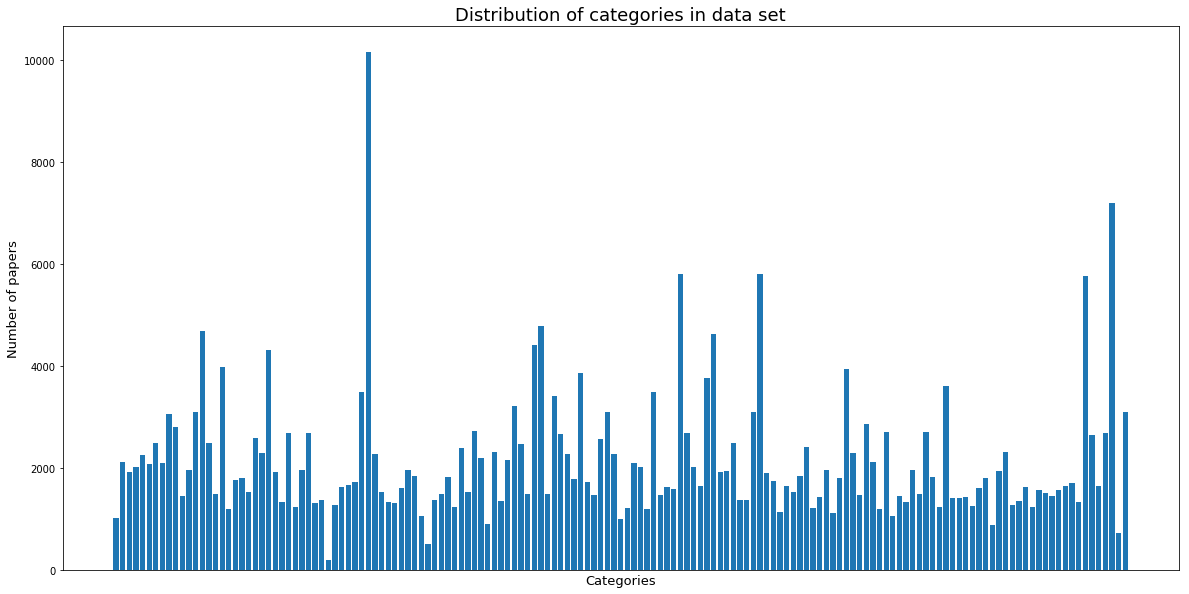

In [8]:
# plot the distribution of the amount of papers in each category
plt.figure(figsize=(20,10))
plt.bar(x=sum_cats.keys(), height=sum_cats.values)
plt.xlabel('Categories', fontsize=13)
plt.ylabel('Number of papers', fontsize=13)
plt.title('Distribution of categories in data set', fontsize=18)
plt.xticks([])
plt.show()

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

In [9]:
# get dataframe with category codes and descriptions
cat_df = pd.read_csv("cats.csv")

# add the counts to the dataframe and sort 
cat_df['count'] = sum_cats.values
cat_df = cat_df.sort_values(by=['count'], ascending=False)

cat_df.head(5)

,category,description,count
38,cs.LG,Learning,10150
150,stat.ML,Machin...,7182
97,math-ph,Mathem...,5801
85,math.MP,Mathem...,5801
146,quant-ph,Quantu...,5762


<h2> ELMo feature extraction </h2>

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will need the following extra packages.

Next, we download the ELMo model. It is over 350mb in size, so it might take a little while.

In [ ]:
# download the ELMo model, only compile this the first time
#!mkdir elmo
#!curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC elmo

We now need to extract ELMo features from our cleaned text data. This takes a LONG time (potentially many days) and will usually crash if run in a notebook. Instead this is done using the Python extractor which can be downloaded from

<p><center><a href="https://github.com/saattrupdan/scholarly/blob/master/extract_elmo.py"> https://github.com/saattrupdan/scholarly/blob/master/extract_elmo.py </a></center></p>

This is then run with the data file as input without its file extension. For instance, the following extracts the features from the <tt>arxiv.csv</tt> file and saves the features as <tt>arxiv_elmo.pickle</tt>:

<p><center><tt>$ python extract_elmo.py arxiv</tt></center></p>

In the interest of time, however, I provide here download links to the pickle files containing the ELMo data for the <tt>arxiv.csv</tt> and <tt>arxiv_small.csv</tt> data files:

<p><center><tt>$ python extract_elmo.py arxiv</tt></center></p>

This is then run with the data file as input without its file extension. For instance, the following extracts the features from the <tt>arxiv.csv</tt> file and saves the features as <tt>arxiv_elmo.pickle</tt>:

<p><center><tt>$ python extract_elmo.py arxiv</tt></center></p>

Assuming the ELMo features have now been extracted, we now load them in.

In [10]:
# load ELMo data
with open(f"{file_name}_elmo.pickle", "rb") as pickle_in:
    elmo_data = pickle.load(pickle_in)

print(f"ELMo data loaded from {file_name}_elmo.pickle.")

FileNotFoundError: [Errno 2] No such file or directory: 'arxiv_small_elmo.pickle'

<h2> Building the model </h2>

We are now done manipulating our data, and the time has come to build a model. We will be building a logistic regression model for every category.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
Y_test = []
Y_hat = []
lregs = np.asarray([])

for cat in cats:
        
    X_train, X_test, y_train, y_test = train_test_split(elmo_data, df[cat], random_state=4, test_size=0.2)
    Y_test.append(y_test)
    
    try:
        lreg = LogisticRegression(C=0.0001, solver='liblinear')
        lreg.fit(X_train, y_train)
        Y_hat.append(lreg.predict(X_test))
        lregs.append(lreg)
    except:
        Y_hat.append(np.array([0] * len(y_test)))

with open(f"{file_name}_model.pickle","wb") as pickle_out:
    pickle.dump(lregs, pickle_out)
        
print(f"Model built and saved to {file_name}_model.pickle")

<h2> Testing the model </h2>

We now check whether our model is capable of predicting the categories for the papers in our test set.

In [ ]:
from sklearn.metrics import f1_score
from statistics import mean

In [ ]:
f1s = [f1_score(x, y) for (x,y) in zip(Y_test, Y_hat)]

print(f"The average f1 score for the model is {mean(f1s)}.")